In [0]:
import glob
import torch 
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.image as img
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount("./gdrive")

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [3]:
import os 
os.getcwd()

'/content'

In [4]:
%cd './gdrive/My Drive/Assignment 5 Dataset'

/content/gdrive/My Drive/Assignment 5 Dataset


In [0]:
#Transformations such normalization are necessary sometimes and should be applied to datasets
#Train and test set may require different set of tranforms
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

#other transformation that you can use
#transforms.RandomRotation(angle in degrees)
#transforms.Resize((w, h))
#transforms.CenterCrop(size)
# color jittering and many more
# for more details please check https://pytorch.org/docs/stable/torchvision/transforms.html

#The output of torchvision datasets are PILImage images of range [0, 1]. 
#We transform them to Tensors of normalized range [-1, 1].


# **Train Loader**

In [6]:
data_dir = '/content/gdrive/My Drive/Assignment 5 Dataset'
train_dataset = datasets.ImageFolder(data_dir+'/train', transform=train_transform)
print(train_dataset)
covid_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, 
                                        shuffle=True, num_workers=8)
classes = train_dataset.classes
print(classes)

Dataset ImageFolder
    Number of datapoints: 12000
    Root location: /content/gdrive/My Drive/Assignment 5 Dataset/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['infected', 'normal']


# **Validation Loader**

In [7]:
val_dataset = datasets.ImageFolder(data_dir+'/validation', transform=test_transform)
print(val_dataset)
covid_valid = torch.utils.data.DataLoader(val_dataset, batch_size=32, 
                                        shuffle=True, num_workers=8)
classes = val_dataset.classes
print(classes)

Dataset ImageFolder
    Number of datapoints: 1500
    Root location: /content/gdrive/My Drive/Assignment 5 Dataset/validation
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['infected', 'normal']


In [0]:
data_iter = iter(covid_train)
image_, label = data_iter.next()
print(image_.shape)
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1])


In [0]:
data = image_.numpy()
data = data[2,0,:,:]
data = data.squeeze()
print(data.shape)

(224, 224)


normal


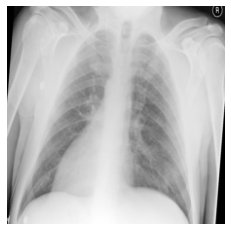

In [0]:
plt.imshow(data, cmap='gray')
plt.axis('off')
print(classes[label[2]])

In [8]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**Freezing Features(Convolutional Layers)**

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

**Removing FC Layers**


In [10]:
num0_features = vgg16.classifier[0].in_features
features = list([nn.Linear(num0_features, 400), nn.ReLU(inplace=True), nn.Dropout(p=0.5) ,nn.Linear(400, len(classes))])
print(features)

[Linear(in_features=25088, out_features=400, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=400, out_features=2, bias=True)]


In [11]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#some hyper parameters
learning_rate = 0.001
Epochs = 5

criterion = nn.CrossEntropyLoss() #loss function

In [0]:
def train_model(dataloader, model, savepath,  epochs=5):
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) #optimizers: stochastic gradient descent, Adam, Adagrad

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)
  model.to(device)

  model.train()
  accuracies={'train': [], 'valid': []}
  cummulative_loss={'train': [], 'valid': []}

  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      pbar = tqdm(enumerate(dataloader))
      for i, data in pbar:
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()
          # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
          # because PyTorch accumulates the gradients on subsequent backward passes. 
          # This is convenient while training RNNs. 
          # So, the default action is to accumulate the gradients on every loss.backward() call

          # forward + backward + optimize
          outputs = model(inputs)               #----> forward pass
          loss = criterion(outputs, labels)   #----> compute loss
          loss.backward()                     #----> backward pass
          optimizer.step()                    #----> weights update

          # print statistics
          running_loss += loss.item()
        
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(dataloader.dataset),
                  100. * i / len(dataloader),
                  loss.data), refresh=True)
      
      result_tr = accuracy(covid_train, model)
      result_va = accuracy(covid_valid, model)

      accuracies['train'].append(result_tr[0])
      accuracies['valid'].append(result_tr[0])
 
      cummulative_loss['train'].append(result_va[1])
      cummulative_loss['valid'].append(result_va[1])

  torch.save(model.state_dict(), savepath)

  print('Finished Training')
  return (accuracies,cummulative_loss, epochs)

# **Accuracy Func**

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def accuracy(dataloader, model):
  correct = 0
  total = 0
  True_norm = 0
  True_infect = 0
  False_norm = 0
  False_infect = 0 
  loss= []
  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss.append(criterion(outputs, labels).data.item())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          True_norm += (labels[predicted==1] == 1).sum().item() #TP
          True_infect += (labels[predicted==0] == 0).sum().item() #TN
          False_norm += (labels[predicted==1] == 0).sum().item() #FP
          False_infect += (labels[predicted==0] == 1).sum().item() #FN

  print('Accuracy of the network on the', total ,'test images: %d %%' % (
      100 * correct / total))
  accuracy = 100 * correct / total
  mean_loss = np.mean(np.array(loss))
  return (accuracy, mean_loss, True_norm, True_infect, False_norm, False_infect)

# **Training VGG-16**

In [15]:
report_train_vgg = train_model(covid_train, vgg16, 'vgg16_FC_Only.pth')

cuda:0


Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.275435: : 375it [02:08,  2.92it/s]


Accuracy of the network on the 12000 test images: 89 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.245491: : 375it [02:09,  2.90it/s]


Accuracy of the network on the 12000 test images: 91 %
Accuracy of the network on the 1500 test images: 90 %


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.323497: : 375it [02:10,  2.87it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 90 %


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.190631: : 375it [02:11,  2.84it/s]


Accuracy of the network on the 12000 test images: 89 %
Accuracy of the network on the 1500 test images: 90 %


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.116009: : 375it [02:12,  2.83it/s]


Accuracy of the network on the 12000 test images: 91 %
Accuracy of the network on the 1500 test images: 90 %
Finished Training


# **Loading Test Data**

In [16]:
test_dataset = datasets.ImageFolder(data_dir+'/test', transform=test_transform)
print(test_dataset)
covid_test = torch.utils.data.DataLoader(test_dataset, batch_size=32, 
                                        shuffle=True, num_workers=8)

Dataset ImageFolder
    Number of datapoints: 1500
    Root location: /content/gdrive/My Drive/Assignment 5 Dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


# **Resnet**

In [17]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Freezing Parameters**

In [0]:
for param in resnet18.parameters():
      param.require_grad = False

# **Removing FC Layers**

In [0]:
num0_features = resnet18.fc.in_features
features = list([nn.Linear(num0_features, 400), nn.ReLU(inplace=True), nn.Dropout(p=0.5), nn.Linear(400, len(classes))])

In [20]:
resnet18.fc = nn.Sequential(*features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Training Resnet**

In [21]:
report_train_resnet = train_model(covid_train, model=resnet18, savepath='resnet18_ft.pth')

cuda:0


Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.143107: : 375it [02:01,  3.10it/s]


Accuracy of the network on the 12000 test images: 88 %
Accuracy of the network on the 1500 test images: 87 %


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.132171: : 375it [02:01,  3.09it/s]


Accuracy of the network on the 12000 test images: 89 %
Accuracy of the network on the 1500 test images: 88 %


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.165387: : 375it [02:02,  3.07it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.123996: : 375it [02:02,  3.06it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.292223: : 375it [02:02,  3.06it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 89 %
Finished Training


# **Accuracy of Resnet**

In [38]:
report_test_resnet = accuracy(covid_test, resnet18)

Accuracy of the network on the 1500 test images: 95 %


# **Accuracy of VGG**

In [37]:
report_test_vgg = accuracy(covid_test, vgg16)

Accuracy of the network on the 1500 test images: 96 %


# **Task 2**

# **Defining Models VGG-16 & RESNET-18**

In [0]:
resnet18_2 = models.resnet18(pretrained=True)
vgg16_2 = models.vgg16(pretrained=True)

# **Replacing FC Layers**

In [0]:
resnet_num0_features = resnet18_2.fc.in_features
resnet_features = list([nn.Linear(resnet_num0_features, 400), nn.ReLU(inplace=True), nn.Dropout(p=0.5), nn.Linear(400, len(classes))])

vgg_num0_features = vgg16_2.classifier[0].in_features
vgg_features = list([nn.Linear(vgg_num0_features, 400), nn.ReLU(inplace=True), nn.Dropout(p=0.5), nn.Linear(400, len(classes))])


resnet18_2.fc = nn.Sequential(*resnet_features)
vgg16_2.classifier = nn.Sequential(*vgg_features)

# **Randomly freezing in VGG-16**

---


In [0]:
freeze=[0,7,9,19,20,24]
i=0
for param in vgg16_2.features.parameters():
    if i in freeze:
      param.require_grad = False
    i+=1

In [28]:
report_train_vgg_2 = train_model(covid_train, model=vgg16_2, savepath='vgg16_2_entire.pth')

cuda:0


Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.164355: : 375it [02:10,  2.86it/s]


Accuracy of the network on the 12000 test images: 89 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.128190: : 375it [02:12,  2.82it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.287968: : 375it [02:12,  2.83it/s]


Accuracy of the network on the 12000 test images: 91 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.106105: : 375it [02:12,  2.83it/s]


Accuracy of the network on the 12000 test images: 91 %
Accuracy of the network on the 1500 test images: 91 %


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.423810: : 375it [02:12,  2.83it/s]


Accuracy of the network on the 12000 test images: 92 %
Accuracy of the network on the 1500 test images: 91 %
Finished Training


In [45]:
report_test_vgg_2 = accuracy(covid_test, vgg16_2)

Accuracy of the network on the 1500 test images: 97 %


# **Randomly freezing in RESNET-18**

---



In [0]:
freeze=[0,12,22,24,36,38,40,49,50,55,57,62]
i=0
for param in resnet18_2.parameters():
    if i in freeze:
      param.require_grad = False
    i+=1

In [48]:
report_train_resnet_2 = train_model(covid_train, model=resnet18_2, savepath='resnet18_2_entire.pth')

cuda:0


Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.404949: : 375it [02:01,  3.08it/s]


Accuracy of the network on the 12000 test images: 88 %
Accuracy of the network on the 1500 test images: 87 %


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.147049: : 375it [02:02,  3.07it/s]


Accuracy of the network on the 12000 test images: 89 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.390278: : 375it [02:02,  3.06it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.172354: : 375it [02:03,  3.03it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 90 %


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.280011: : 375it [02:03,  3.03it/s]


Accuracy of the network on the 12000 test images: 91 %
Accuracy of the network on the 1500 test images: 90 %
Finished Training


In [49]:
report_test_resnet_2 = accuracy(covid_test, resnet18_2)

Accuracy of the network on the 1500 test images: 96 %


# **Training Without Freezing**

# **Defining VGG & Resnet**

In [0]:
resnet18_3 = models.resnet18(pretrained=True)
vgg16_3 = models.vgg16(pretrained=True)

# **Removing FC Layers**

In [0]:
resnet3_num0_features = resnet18_3.fc.in_features
resnet3_features = list([nn.Linear(resnet3_num0_features, 400), nn.ReLU(inplace=True), nn.Dropout(p=0.5), nn.Linear(400, len(classes))])

vgg3_num0_features = vgg16_3.classifier[0].in_features
vgg3_features = list([nn.Linear(vgg3_num0_features, 400), nn.ReLU(inplace=True), nn.Dropout(p=0.5), nn.Linear(400, len(classes))])


resnet18_3.fc = nn.Sequential(*resnet3_features)
vgg16_3.classifier = nn.Sequential(*vgg3_features)

# **Training VGG**

In [56]:
report_train_vgg_3 = train_model(covid_train, model=vgg16_3, savepath='vgg16_3_entire.pth')

cuda:0


Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.299369: : 375it [02:12,  2.82it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.188260: : 375it [02:13,  2.81it/s]


Accuracy of the network on the 12000 test images: 89 %
Accuracy of the network on the 1500 test images: 87 %


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.109293: : 375it [02:12,  2.83it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 87 %


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.472911: : 375it [02:12,  2.83it/s]


Accuracy of the network on the 12000 test images: 91 %
Accuracy of the network on the 1500 test images: 90 %


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.243924: : 375it [02:12,  2.83it/s]


Accuracy of the network on the 12000 test images: 92 %
Accuracy of the network on the 1500 test images: 90 %
Finished Training


# **Training Resnet**

In [58]:
report_train_resnet_3 = train_model(covid_train, model=resnet18_3, savepath='resnet18_3_entire.pth')

cuda:0


Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.219210: : 375it [02:02,  3.06it/s]


Accuracy of the network on the 12000 test images: 88 %
Accuracy of the network on the 1500 test images: 88 %


Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.194779: : 375it [02:03,  3.05it/s]


Accuracy of the network on the 12000 test images: 89 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.196546: : 375it [02:02,  3.05it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 88 %


Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.219647: : 375it [02:03,  3.04it/s]


Accuracy of the network on the 12000 test images: 90 %
Accuracy of the network on the 1500 test images: 89 %


Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.359580: : 375it [02:02,  3.06it/s]


Accuracy of the network on the 12000 test images: 91 %
Accuracy of the network on the 1500 test images: 90 %
Finished Training


# **Accuracy of vgg & Resnet**

In [59]:
report_test_vgg_3 = accuracy(covid_test, vgg16_3)
report_test_resnet_3 = accuracy(covid_test, resnet18_3)

Accuracy of the network on the 1500 test images: 96 %
Accuracy of the network on the 1500 test images: 95 %


# **Summarizing**

In [0]:
def display_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])


In [0]:
def calculate_F1(TP, TN, FP, FN):
  precision = TP/ (TP+FP)
  recall = TP/ (TP+FN)
  f1 = 2 * (precision * recall) / (precision + recall)
  print('Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}'.format(precision, recall, f1))
  

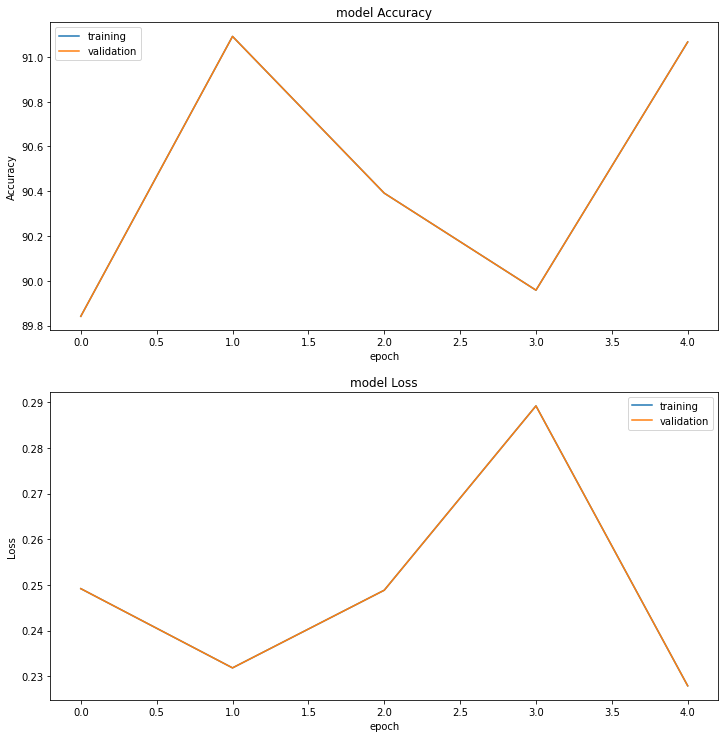

In [35]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_curves(report_train_vgg[0]['train'],report_train_vgg[0]['valid'], 'Accuracy', 211 )
display_curves(report_train_vgg[1]['train'],report_train_vgg[1]['valid'], 'Loss', 212 )

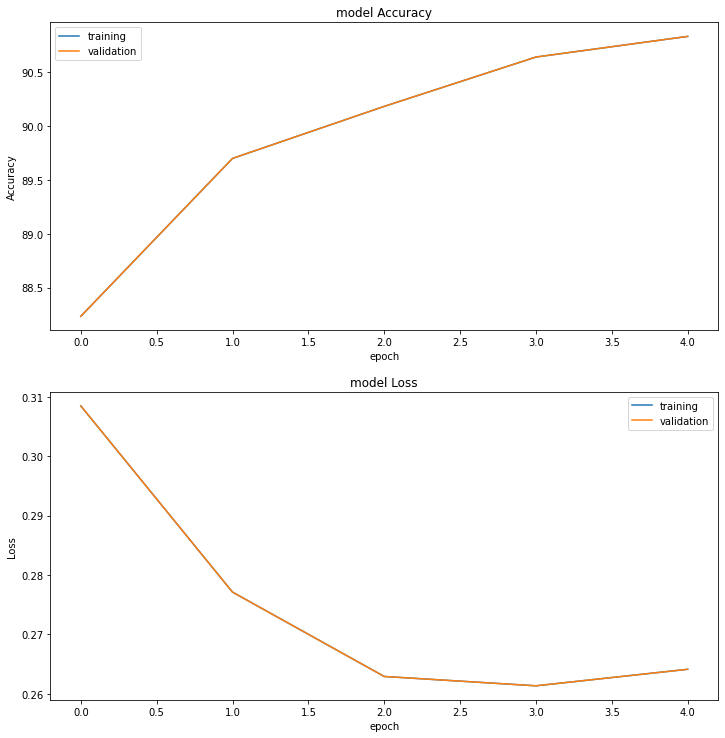

In [44]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_curves(report_train_resnet[0]['train'],report_train_resnet[0]['valid'], 'Accuracy', 211 )
display_curves(report_train_resnet[1]['train'],report_train_resnet[1]['valid'], 'Loss', 212 )

In [42]:
calculate_F1(report_test_vgg[2], report_test_vgg[3], report_test_vgg[4], report_test_vgg[5])
calculate_F1(report_test_resnet[2], report_test_resnet[3], report_test_resnet[4], report_test_resnet[5])

Precsion: 0.95, Recall: 0.99, F1: 0.97
Precsion: 0.95, Recall: 0.98, F1: 0.96


In [43]:
print(report_test_vgg)
print(report_test_resnet)

(96.2, 0.12127179953646153, 879, 564, 51, 6)
(95.8, 0.13872070919643056, 864, 573, 42, 21)


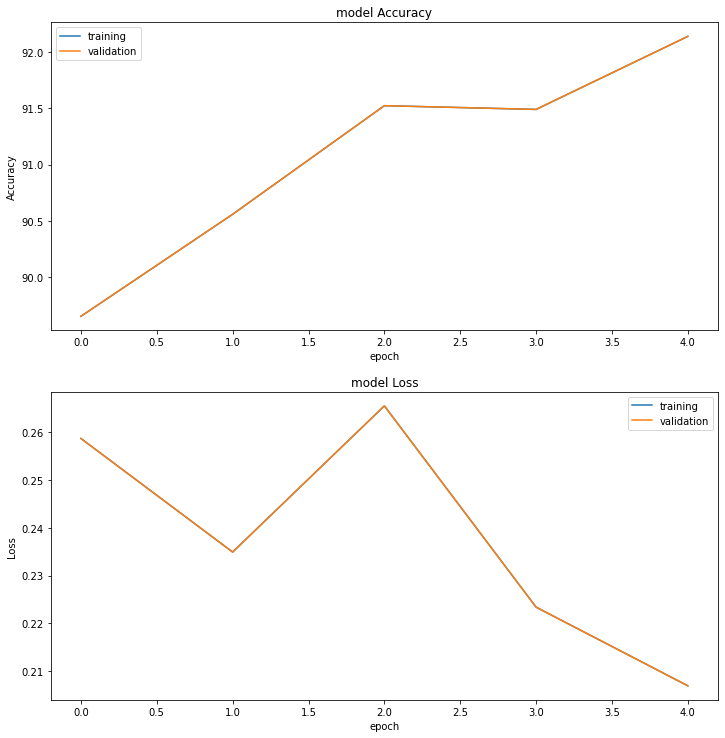

In [50]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_curves(report_train_vgg_2[0]['train'],report_train_vgg_2[0]['valid'], 'Accuracy', 211 )
display_curves(report_train_vgg_2[1]['train'],report_train_vgg_2[1]['valid'], 'Loss', 212 )

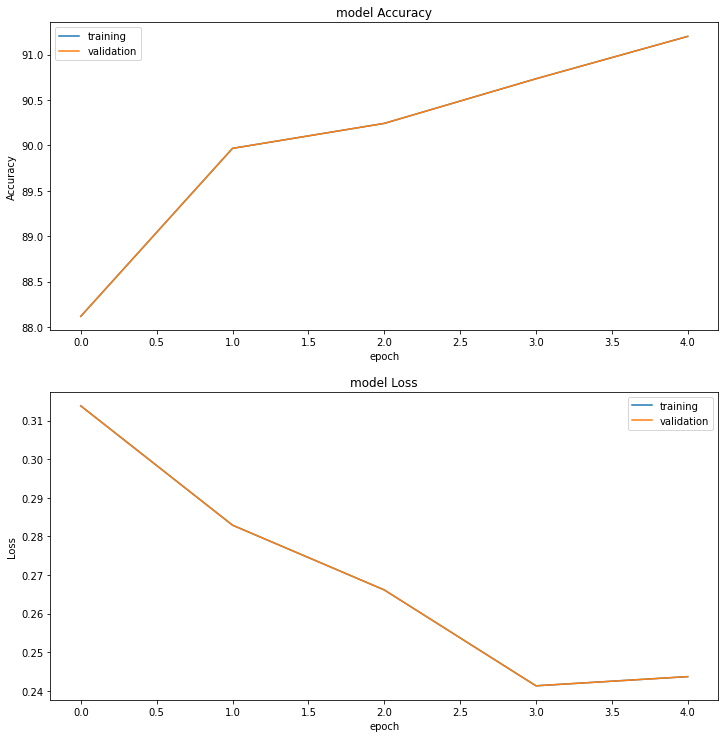

In [51]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_curves(report_train_resnet_2[0]['train'],report_train_resnet_2[0]['valid'], 'Accuracy', 211 )
display_curves(report_train_resnet_2[1]['train'],report_train_resnet_2[1]['valid'], 'Loss', 212 )

In [52]:
calculate_F1(report_test_vgg_2[2], report_test_vgg_2[3], report_test_vgg_2[4], report_test_vgg_2[5])
calculate_F1(report_test_resnet_2[2], report_test_resnet_2[3], report_test_resnet_2[4], report_test_resnet_2[5])

Precsion: 0.97, Recall: 0.99, F1: 0.98
Precsion: 0.96, Recall: 0.98, F1: 0.97


In [53]:
print(report_test_vgg_2)
print(report_test_resnet_2)

(97.06666666666666, 0.09755113863564552, 872, 584, 31, 13)
(96.33333333333333, 0.12165883445042244, 866, 579, 36, 19)


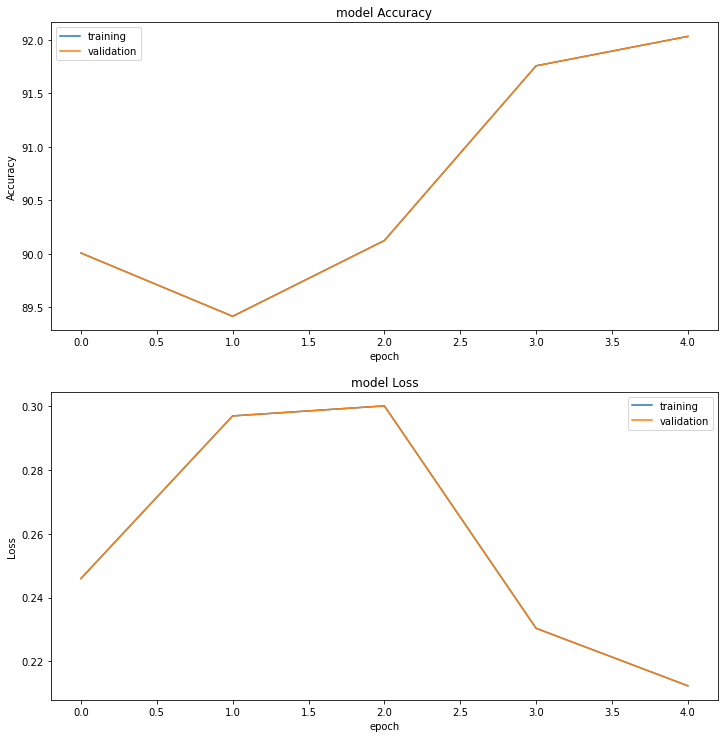

In [57]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_curves(report_train_vgg_3[0]['train'],report_train_vgg_3[0]['valid'], 'Accuracy', 211 )
display_curves(report_train_vgg_3[1]['train'],report_train_vgg_3[1]['valid'], 'Loss', 212 )

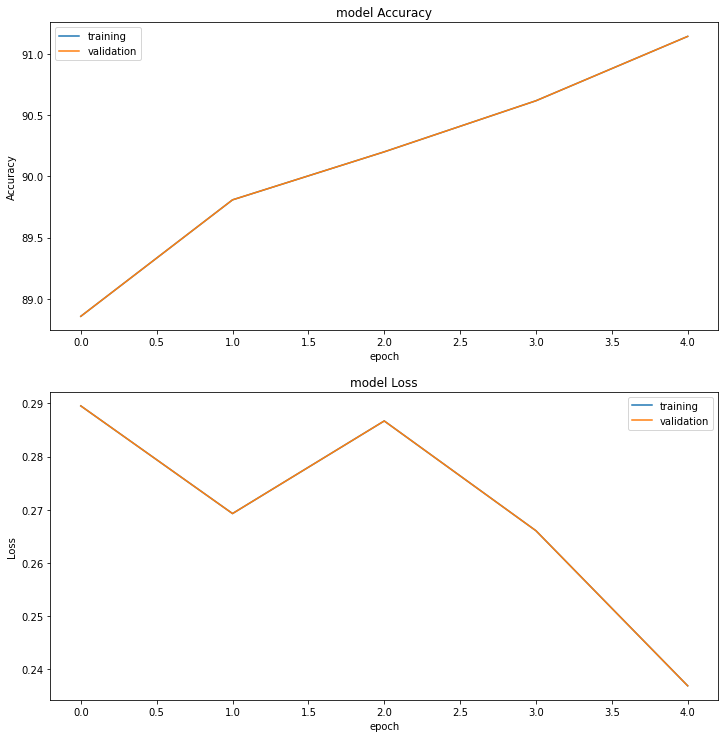

In [60]:
plt.subplots(figsize=(10,10))
plt.tight_layout()
display_curves(report_train_resnet_3[0]['train'],report_train_resnet_3[0]['valid'], 'Accuracy', 211 )
display_curves(report_train_resnet_3[1]['train'],report_train_resnet_3[1]['valid'], 'Loss', 212 )

In [61]:
calculate_F1(report_test_vgg_3[2], report_test_vgg_3[3], report_test_vgg_3[4], report_test_vgg_3[5])
calculate_F1(report_test_resnet_3[2], report_test_resnet_3[3], report_test_resnet_3[4], report_test_resnet_3[5])

Precsion: 0.96, Recall: 0.99, F1: 0.97
Precsion: 0.95, Recall: 0.98, F1: 0.96


In [62]:
print(report_test_vgg_3)
print(report_test_resnet_3)

(96.93333333333334, 0.1079718844687685, 876, 578, 37, 9)
(95.73333333333333, 0.1364778919105834, 867, 569, 46, 18)
